In [1]:
import webbrowser

###### Content under Creative Commons Attribution license CC-BY 4.0, code under MIT license (c)2015 J.M. Kerwin. Style from Numerical-MOOC (c)2014 L.A. Barba, G.F. Forsyth also under CC-BY.

# An Application of Numerical Methods to DC Motor Control

Welcome to a *proposed* bonus notebook for the first learning module of the course [**"Practical Numerical Methods with Python."**](http://openedx.seas.gwu.edu/courses/GW/MAE6286/2014_fall/about)

In this notebook I discuss the application of numerical methods for ordinary differential equations (ODE) of DC motor control for a gimbal system. The focus is the motion profile and motor winding temperature with a demand current input. Here is a great general overview of [DC Motor Theory](http://hades.mech.northwestern.edu/index.php/Brushed_DC_Motor_Theory) relating specifically to the Maxon motors presented in this exercise.

What is a gimbal? It is a device for controlling rotation around an axis. The most common example is in a pan-tilt security camera, which is a two-stage gimbal. For a general description of a gimbal, reference ["Gimbal-Wikipedia."](https://en.wikipedia.org/wiki/Gimbal) A linear and rotary positioning machine manufacturer, [Newmark Systems](http://www.newmarksystems.com/gimbal-mounts/), shows a great example of a moving two-stage gimbal in the video below. The azimuth stage is represented by rotation about the vertical axis, and the elevation stage is represented by rotation about a horizontal axis. Note the cube DC stepper motors mounted to each of the stages and the external cables connected bewteen the first and second stage indicating that the azimuth stage has a limitied rotation of about 360 degrees.


In [2]:
from IPython.display import YouTubeVideo
YouTubeVideo('wOK12HZSbu4')

Figure 1. below shows a visual of the design layout for the stages and payload for this exercise. The gimbal and payload specifications are as follows:

**Payload Specification**
* Dimensions: $48x11x7$ $in.$
* Mass moment of inertia for the Azimuth Stage: $26.831$ $kgm^2$
* The total speed reducing (torque increasing) drive ratio for this setup is $300:1$ due to a pulley drive ratio of $3:1$

![Image](./figures/Block_Gimbal_Layout.png)
#### Figure 1. Block gimbal design layout for this exercise.

**[Maxon Motor](http://www.maxonmotorusa.com) hardware**
* Maxon EPOS2 70/10 controller part number 375711
* Maxon Planetary gearhead GP62A with 100:1 gear ratio part number 110505
* Maxon EC45 DC brushless motor part number 136210
* $V_\rm{applied}=28$ $Volts$
* $I_\rm{max}=25$ $Amps$
* $P_\rm{max}=500$ $Watts$

In [4]:
# Open the PDFs for the Maxon Equipment
webbrowser.open_new('./resources/Maxon_375711.pdf');
webbrowser.open_new('./resources/Maxon_110505.pdf');
webbrowser.open_new('./resources/Maxon_136210.pdf');

**Functional Requirements**
* Focus on the Azimuth stage only
* Determine Acceleration Profile
* Determine Velocity Profile
* Determine Position Profile
* Determine the Input Current profile for starting at $0^{\circ}$ and stopping at $360^{\circ}$, modeled as a constant current step function
* Determine the time to complete the rotation
* Determine maximum motor winding temperature

**Environmental Factors**
* Operate during a wind velocity of $178$ $MPH$ - The estimated wind induced torque is modeled after an [ICAS](http://www.icas.org) research paper on rectangular prisms as airfoils

## Derivation of Equations

In [5]:
#Reference Maxon Motor Theory for Equations and Principles
webbrowser.open_new('./resources/Maxon_Motor_Notes.pdf');
webbrowser.open_new('./resources/Maxon_Motor_Technical_Equations.pdf');


**Conservation of Power**

Mechanical power in the form of torque times angular velocity is induced from the applied motor current and voltage. 
$$Power_\rm{mechanical} = I_\rm{applied}V_\rm{induced} = \tau_\rm{motor}\omega$$

Losses exist in the form of resistance (heat) and inductance (delay)...
$$V_\rm{applied} = V_\rm{induced}+RI_\rm{applied}+L\frac{dI}{dt}$$

Solving for $V_\rm{induced}$ and substituting into the power equation...
$$I_\rm{applied}(V_\rm{applied}-RI_\rm{applied}-L\frac{dI}{dt}) = \tau_\rm{motor}\omega$$

The inductance value for this motor is $0.0565$ $mH$. Limiting the applied current ramp rate to $1000$ $Amps$ per second will keep any inductance effects lower than $0.0565$ $Volts$. With an applied motor voltage of $28$ $Volts$, this is less than $0.2$ percent. Therefore the $LdI/dt$ term can be neglected and removed from the equation. This is consistent with accepted practice for DC motors.

$$I_\rm{applied}(V_\rm{applied}-RI_\rm{applied}) = \tau_\rm{motor}\omega$$

Total torque is a combination of motor torque and external input torque due to a wind induced moment (yaw moment for the azimuth stage).
$$\tau_\rm{total} = \tau_\rm{motor}+\tau_\rm{environmental} = I_\rm{inertia}\alpha$$

Solving for $\tau_\rm{motor}$ and substituting into the power equation...
$$I_\rm{applied}(V_\rm{applied}-RI_\rm{applied}) = (I_\rm{inertia}\alpha-\tau_\rm{environmental})\omega$$

This is the controlling equation for motion of the gimbal azimuth stage.  Let's rearrange and solve for $\alpha$.
$$\alpha = \frac{I_\rm{applied}(V_\rm{applied}-RI_\rm{applied})}{I_\rm{inertia}\omega}-\frac{\tau_\rm{environmental}}{I_\rm{inertia}}$$

Now let's rearrange into a derivative form...
$$ \frac{\omega^{n+1}-\omega^n}{\Delta t}= \frac{I_\rm{applied}(V_\rm{applied}-RI_\rm{applied})}{I_\rm{inertia}\omega^n}-\frac{\tau_\rm{environmental}}{I_\rm{inertia}}$$

Solving for $\omega^{n+1}$
$$ \omega^{n+1}= \omega^n+\Delta t(\frac{I_\rm{applied}(V_\rm{applied}-RI_\rm{applied})}{I_\rm{inertia}\omega^n}-\frac{\tau_\rm{environmental}}{I_\rm{inertia}})$$

**Motor Winding Temperature**

Motor winding resistance is a function of temperature and represented by
$$R_\rm{T}= R_\rm{25}(1+\alpha_\rm{cu}(T-25^{\circ}C))$$

Where the thermal resistance coefficent for copper is $\alpha_\rm{cu} =0.0039$

Using a [time constant LTI system differential equation](https://en.wikipedia.org/wiki/Time_constant) as a basis for the thermal equation for the motor winding temperature
$$\frac{\Delta T}{dt} + \frac{T-25^{\circ}C}{\tau} = R_\rm{thermal}I_\rm{applied}^2R_\rm{T}$$

Where the thermal resistance for the housing and windings is $R_\rm{thermal} = (1.7+1.1)^{\circ}K/Watt$ and the thermal time constant $\tau=31$ $Seconds$

Substituting the $R_\rm{T}$ into the LTI equation
$$\frac{\Delta T}{dt} + \frac{T-25^{\circ}C}{\tau} = R_\rm{thermal}I_\rm{applied}^2(R_\rm{25}(1+\alpha_\rm{cu}(T-25^{\circ}C)))$$

Solving for $\Delta T$ and arranging in derivative form
$$\frac{T^{n+1}-T^n}{\Delta t}  = R_\rm{thermal}I_\rm{applied}^2(R_\rm{25}(1+\alpha_\rm{cu}(T^n-25^{\circ}C)))- \frac{T^n-25^{\circ}C}{\tau}$$

Solving for $T^{n+1}$
$$T^{n+1}  = T^n+\Delta t(R_\rm{thermal}I_\rm{applied}^2(R_\rm{25}(1+\alpha_\rm{cu}(T^n-25^{\circ}C)))- \frac{T^n-25^{\circ}C}{\tau})$$

**Environmental Torque**

In [6]:
#Open the PDF for the ICAS 155 Airfoil Paper for yaw moment approximations
webbrowser.open_new('./resources/International_council_of_aeronautical_sciences155.pdf');

The estimated wind induced torque as a function of payload roation angle for a 3D rectangular prism body is calculated using the yaw moment coefficient from equation $7$ in the ICAS 155 paper above. That yaw moment coefficient is then combined with a wind pressure, area and chord length to achieve an estimated yaw moment. This equation does not require a derived numerical solution, it is simply a function of the current rotational position.

$$\tau_\rm{environmental} = (0.09(1-(\frac{Width}{Length})^2)sin(2\theta_\rm{payload})-.04*\frac{Width}{Length}sin(4\theta_\rm{payload}))*0.00256V^2A_\rm{face}L_\rm{chord}$$
    

## Approximation of the Expected Result

In [7]:
%matplotlib inline
import numpy 
from matplotlib import pyplot, rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

A general trapezoidal velocity profile is a great place to start to get a visual of the potential outcome and a rough order of magnitude on the cycle time. The figures below show the velocity profile and the corresponding acceleration and position profiles. Note that these first-order (from a design standpoint, not convergence!) approximation profiles do not take into account the external wind induced torque or any motor specifics like friction, resistance, power losses, and delays. The profiles can be used as a basis for comparison to the results of the numerical solution.

The trapezoidal velocity profile method cycle time is  8.2 Seconds.


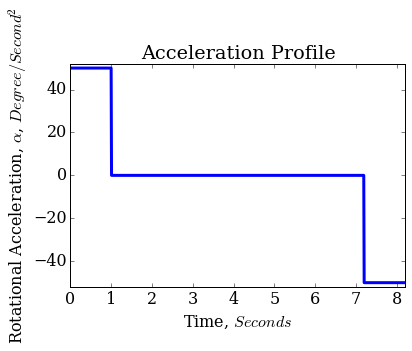

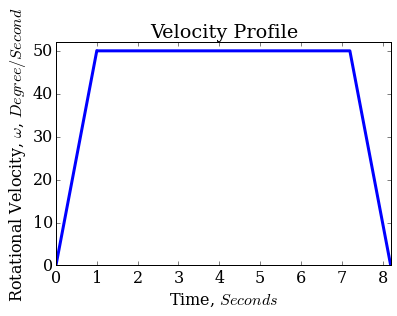

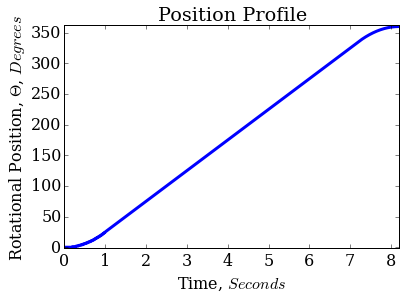

In [8]:
acc = 50
vel = 50
dt=100
j=dt+1
timemax = 1+(360-2*acc/2)/vel+1
time = numpy.linspace(0,timemax,timemax*dt+1)

aprofile = numpy.zeros(len(time))
aprofile[:j]=acc
aprofile[-j:]=-acc
vprofile = numpy.zeros(len(time))
vprofile[:] = vel
vprofile[:j]=acc*time[:j]
vprofile[-j:]=-acc*(time[-j:]-time[-j])+vel
thetaprofile = aprofile*time**2//2
thetaprofile[j:]=vprofile[j:]*(time[j:]-.5)
thetaprofile[-j:]=aprofile[-j:]*(time[-j:]-time[-j])**2/2+vel*(time[-j:]-.5)

pyplot.plot(time, aprofile, color='blue', ls='-', lw=3)
pyplot.title('Acceleration Profile')
pyplot.ylabel('Rotational Acceleration, $\\alpha$, $Degree/Second^2$')
pyplot.xlabel('Time, $Seconds$')
pyplot.xlim(0,timemax);
pyplot.ylim(-acc-2,acc+2);
pyplot.figure(2)
pyplot.plot(time, vprofile, color='blue', ls='-', lw=3)
pyplot.title('Velocity Profile')
pyplot.ylabel('Rotational Velocity, $\omega$, $Degree/Second$')
pyplot.xlabel('Time, $Seconds$')
pyplot.xlim(0,timemax);
pyplot.ylim(0,vel+2);
pyplot.figure(3)
pyplot.plot(time, thetaprofile, color='blue', ls='-', lw=3)
pyplot.title('Position Profile');
pyplot.ylabel('Rotational Position, $\Theta$, $Degrees$');
pyplot.xlabel('Time, $Seconds$')
pyplot.xlim(0,timemax);
pyplot.ylim(0-2,360+2);
print('The trapezoidal velocity profile method cycle time is ',timemax,'Seconds.');

## Let the Coding Begin

Now that the equations and base comparison profiles are in order, let's setup the demand current and voltage profiles for solving the numerical solution. The current profile for this exercise is a ramped square wave current input. The voltage is mapped after the current profile with a maximum of $28$ $Volts$ and a power maximum of $IV = 500$ $Watts$.

In [9]:
def Ivalues(Imax,Itimemax,Icontinuous,Iramprate,Itimecontinuous,N):
    I = numpy.zeros(N)
    I[:] = Icontinuous
    I[0] = 0.0
    for i in range(1,T1): #ramp up
        I[i] = Iramprate*(dt*i)
    for i in range(T1,T2): #dwell at max
        I[i] = Imax
    for i in range(T2,T3): #ramp down
        I[i] = Imax - Iramprate*(dt*(i-T2))
    for i in range(T3,T4): #dwell at continuous
        I[i] = Icontinuous
    for i in range(T4,T5): #ramp up
        I[i] = Icontinuous - Iramprate*(dt*(i-T4))
    for i in range(T5,T6): #dwell at max
        I[i] = -Imax
    for i in range(T6,T7): #ramp down
        I[i] = -Imax + Iramprate*(dt*(i-T6)) 
    return I[:]

In [10]:
def Vvalues(I,N):
    V = numpy.zeros(N)
    V[:]=0.0
    for i in range(0,N):
        if I[i]==0:
            V[i]=28
        elif abs(500/I[i])>28:
            V[i]=28
        else:
            V[i]=abs(500/I[i] )  
    return V[:]

The initial setup is coded below. The total time $T$ is intentionally longer than the expected cycle time of $0^{\circ}$ to $360^{\circ}$ to allow for capturing the full temperature decay profile of the motor winding. A $\Delta t$ of $0.0001$ $Seconds$ is chosen based on the maximum ramp rate of the demand current $1000$ $Amps/Second$ (the demand current changes no more than $.1$ $Amps/\Delta t$) and the processing time required for a smaller $\Delta t$. Values marked with a triple comment (###) are pulled directly from the Maxon motor specifications and equations cited above.

In [11]:
#Intitial setup
T = 100 #Seconds
Tinitial = T
dt = 0.0001 #Time step Seconds
N = int(T/dt)+1
t = numpy.linspace(0.0, T, N)

R = 0.143 ###Ohms
Ratio = 300 # Speed Reducing Ratio
Inertia = 26.831/Ratio #kg-m^2 Payload inertia 

Rthermal = 1.7+1.1 ###Degrees K per Watt
acu = 0.0039 ###Thermal resistance coefficeint for copper
Tamb = 25 #Degrees C
Thermaltimeconstant =31 ###Seconds

#Payload specs for TAUenvironmental
Windspeed = 155*1.1508 #MPH
Length = 7/12 #Feet
Width = 48/12 #Teet
Height = 11/12 #Feet

Imax = 500/28 #Amps
Itimemax = 5.81601 #Seconds default(5.81601)
Icontinuous = 0.0 #Amps
Iramprate = 1000 #Amps/Second
Itimecontinuous = 0.0 #Seconds

T1 =      int((Imax/Iramprate)/dt) #ramp up
T2 = T1 + int(Itimemax/dt) #dwell at max
T3 = T2 + int(((Imax-Icontinuous)/Iramprate)/dt) #ramp down
T4 = T3 + int(Itimecontinuous/dt) #dwell at continuous
T5 = T4 + int(((Imax-Icontinuous)/Iramprate)/dt) #ramp up
T6 = T5 + int(Itimemax/dt) #dwell at max
T7 = T6 + int(((Imax-Icontinuous)/Iramprate)/dt) #ramp down

#Initial Conditions
I = Ivalues(Imax,Itimemax,Icontinuous,Iramprate,Itimecontinuous,N) 
V = Vvalues(I,N)
alpha = numpy.zeros(N)
alpha[:] = 0.0#radians/second^2
omega = numpy.zeros(N)
omega[:] = 0.001 #radians/second, note that the initial speed must be greater than 0 to kickstart the numerical solution
theta = numpy.zeros(N)
theta[:] = 0.0#radians
temp = numpy.zeros(N)
temp[:] = Tamb #degrees C
TAUenv = numpy.zeros(N)
TAUenv[:] = 0#Newtons-meters

## Numerical Method

A [two-stage second-order Runge-Kutta Ralston Method](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods) (can a punctuation mark have alliteration?) is used to numerically solve the rotational velocity and motor winding temperature profiles. The choice of method gives a second order of convergence and presents a comparison of methods to a first order Euler solution. Since the equation for omega is non-linear, there is an expectation that a higher order method would benefit the accuracy of the solution. The temperature equation is linear and the benefits of a higher order method are expected to be less.  An L1-norm error is calculated to show the total error difference between the Euler method and the Ralston Method.

The Euler Method, as shown in the second lesson of the first module of the Numerical MOOC class - [Phugoid Oscillation](http://nbviewer.ipython.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/01_phugoid/01_02_Phugoid_Oscillation.ipynb), takes the form of 
$$\omega_{n+1} = \omega_n + \Delta t \,f(\omega_n).$$

The two-stage second-order Runge-Kutta Ralston Method is a little more involved. The first stage is to calculate the current $F(\omega)$ then an $F(\omega)^{\star}$ at a $2/3\Delta t$. Then combine the two solutions at $1/4F(\omega)+3/4F(\omega)^{\star}$

$$F(\omega_n) = F(\omega_n)$$
$$\omega^{\star} = \omega_n + 2/3\Delta t \,F(\omega_n)$$
$$\omega_{n+1} = \omega_n + \Delta t \,(  1/4F(\omega_n)+3/4F(\omega^{\star}))$$

In [12]:
#Using a two-stage second-order Runge-Kutta Ralston Method
omegaEU=omega.copy()
omegaFUNC=omega.copy()
omegastarRK2Ralston=omega.copy()
omegaRK2Ralston=omega.copy()
tempEU=temp.copy()
tempFUNC=temp.copy()
tempstarRK2Ralston=temp.copy()
tempRK2Ralston=temp.copy()

for n in range(1,N):       
    #Euler Method
    omegaEU[n] = omegaEU[n-1] + dt*(I[n-1]*(V[n-1]-(R*(1+acu*(tempRK2Ralston[n-1]-Tamb)))*I[n-1])/(Inertia*omegaEU[n-1]) +TAUenv[n-1]/Inertia)
    #Runge-Kutta 2 Ralston Method
    omegaFUNC[n] = (I[n]*(V[n]-(R*(1+acu*(tempRK2Ralston[n]-Tamb)))*I[n])/(Inertia*omegaEU[n]) +TAUenv[n]/Inertia)
    omegastarRK2Ralston[n] = omegaRK2Ralston[n-1] + (2/3)*dt*(I[n-1]*(V[n-1]-(R*(1+acu*(tempRK2Ralston[n-1]-Tamb)))*I[n-1])/(Inertia*omegaRK2Ralston[n-1]) +TAUenv[n-1]/Inertia)
    omegaRK2Ralston[n] = omegaRK2Ralston[n-1] + dt*(I[n-1]*(V[n-1]-(R*(1+acu*(tempRK2Ralston[n-1]-Tamb)))*I[n-1])/(Inertia*(1/4*omegaFUNC[n-1]+3/4*omegastarRK2Ralston[n-1])) +TAUenv[n-1]/Inertia)       
    
    #Direct Deriviative and Integral
    theta[n] = theta[n-1] + dt*omegaRK2Ralston[n-1]
    alpha[n] = (omegaRK2Ralston[n]-omegaRK2Ralston[n-1])/dt
    
    #Euler Method
    tempEU[n] = tempEU[n-1] + dt*(Rthermal*abs(I[n-1])*(R*(1+acu*(tempEU[n-1]-Tamb)))-tempEU[n-1]/Thermaltimeconstant+Tamb/Thermaltimeconstant)
    #Runge-Kutta 2 Ralston Method
    tempFUNC[n] = (Rthermal*abs(I[n])*(R*(1+acu*(tempFUNC[n]-Tamb)))-tempFUNC[n]/Thermaltimeconstant+Tamb/Thermaltimeconstant)
    tempstarRK2Ralston[n] = tempRK2Ralston[n-1] + (2/3)*dt*(Rthermal*abs(I[n-1])*(R*(1+acu*(tempRK2Ralston[n-1]-Tamb)))-tempRK2Ralston[n-1]/Thermaltimeconstant+Tamb/Thermaltimeconstant)
    tempRK2Ralston[n] = tempRK2Ralston[n-1] + dt*(Rthermal*abs(I[n-1])*(R*(1+acu*((1/4*tempFUNC[n-1]+3/4*tempstarRK2Ralston[n-1])-Tamb)))-(1/4*tempFUNC[n-1]+3/4*tempstarRK2Ralston[n-1])/Thermaltimeconstant+Tamb/Thermaltimeconstant)
    
    #Equation
    TAUenv[n] = -((0.09*(1-(Width/Length)**2)*numpy.sin(2*theta[n]/Ratio)-.04*(Width/Length)*numpy.sin(4*theta[n]/Ratio))*((Windspeed)**2)*.00256*Width*Height*Length)*1.355818/Ratio
    
    if theta[n]>=2*numpy.pi*Ratio:
        theta[n:] = theta[n]
        omegaRK2Ralston[n:] = omegaRK2Ralston[n]
        alpha[n:] = alpha[n]
        timestamp = (n)*dt
        break
        
#Continues solution out to full T time to capture temperature decay
for n in range(int(timestamp/dt),N):
    #Euler Method
    tempEU[n] = tempEU[n-1] + dt*(Rthermal*abs(0)*(R*(1+acu*(tempEU[n-1]-Tamb)))-tempEU[n-1]/Thermaltimeconstant+Tamb/Thermaltimeconstant)
    #Runge-Kutta 2 Ralston Method
    tempFUNC[n] = (Rthermal*abs(0)*(R*(1+acu*(tempFUNC[n-1]-Tamb)))-tempFUNC[n-1]/Thermaltimeconstant+Tamb/Thermaltimeconstant)
    tempstarRK2Ralston[n] = tempRK2Ralston[n-1] + (2/3)*dt*(Rthermal*abs(0)*(R*(1+acu*(tempRK2Ralston[n-1]-Tamb)))-tempRK2Ralston[n-1]/Thermaltimeconstant+Tamb/Thermaltimeconstant)
    tempRK2Ralston[n] = tempRK2Ralston[n-1] + dt*(Rthermal*abs(0)*(R*(1+acu*((1/4*tempFUNC[n-1]+3/4*tempstarRK2Ralston[n-1])-Tamb)))-(1/4*tempFUNC[n-1]+3/4*tempstarRK2Ralston[n-1])/Thermaltimeconstant+Tamb/Thermaltimeconstant)
T = timestamp

Now let's look at the error between the first-order Euler method and the second-order Ralston method. As expected the error difference is significant for the non-linear omega equation and not as significant for the linear temperature equation. Note the progression of the error as time passes.

In [13]:
norm = 1
omegaerror = abs(omegaEU-omegaRK2Ralston)
omegaerror**norm
temperror = abs(tempEU-tempRK2Ralston)
temperror**norm
print('The L-',norm,'norm error between the Euler method and the Ralston Method for a delta t of',dt,'Seconds is an Omega and temperature error of:');
for timetime in range(1,10):
    omegaerrorout =(numpy.sum(omegaerror[:int(timetime/dt)]))**(1/norm)*dt*180/numpy.pi
    temperrorout =(numpy.sum(temperror[:int(timetime/dt)]))**(1/norm)*dt
    print('Omega error of',round(omegaerrorout,1),'Degrees/Second and a Temperature error of',round(temperrorout,2), 'Degrees C. after a time of ',timetime,'Seconds');
omegaerrorout =(numpy.sum(omegaerror[:int(T/dt)]))**(1/norm)*dt*180/numpy.pi
temperrorout =(numpy.sum(temperror[:int(T/dt)]))**(1/norm)*dt
print('Omega error of',round(omegaerrorout,1),'Degrees/Second and a Temperature error of',round(temperrorout,2), 'Degrees C. after a time of ',round(T,4),'Seconds');

The L- 1 norm error between the Euler method and the Ralston Method for a delta t of 0.0001 Seconds is an Omega and temperature error of:
Omega error of 1089.8 Degrees/Second and a Temperature error of 0.01 Degrees C. after a time of  1 Seconds
Omega error of 1456.0 Degrees/Second and a Temperature error of 0.05 Degrees C. after a time of  2 Seconds
Omega error of 1588.4 Degrees/Second and a Temperature error of 0.13 Degrees C. after a time of  3 Seconds
Omega error of 2044.6 Degrees/Second and a Temperature error of 0.24 Degrees C. after a time of  4 Seconds
Omega error of 2792.4 Degrees/Second and a Temperature error of 0.41 Degrees C. after a time of  5 Seconds
Omega error of 3798.2 Degrees/Second and a Temperature error of 0.64 Degrees C. after a time of  6 Seconds
Omega error of 4642.2 Degrees/Second and a Temperature error of 0.93 Degrees C. after a time of  7 Seconds
Omega error of 5037.4 Degrees/Second and a Temperature error of 1.3 Degrees C. after a time of  8 Seconds
Omega e

## Results

The demand current and voltage applied to the motor are plotted below. Note that the current is not at the max of $25Amps$. For a power limited input, in this case the maximum power $IV = 500 Watts$, decreasing the voltage to increase the current has a detrimental effect on the system efficiency. A lower efficiency means that more of the input electrical power is lost as heat in the system which significantly increases motor winding temperatures. A balanced output of higher efficiency and torque is achieved by keeping the voltage at its maximum value and limiting the current maximum to $I = \frac{P_\rm{max}}{V}$.

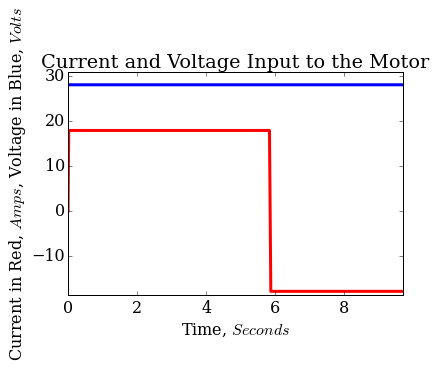

In [31]:
pyplot.plot(t, I, color='red', ls='-', lw=3)
pyplot.plot(t, V, color='blue', ls='-', lw=3)
pyplot.title('Current and Voltage Input to the Motor')
pyplot.ylabel('Current in Red, $Amps$, Voltage in Blue, $Volts$')
pyplot.xlabel('Time, $Seconds$')
pyplot.xlim(0,T);
pyplot.ylim(numpy.amin(I)*1.05,numpy.amax(V)*1.1);

The wind induced torque on the payload (commented out) and the motor are plotted below. The curve is as expected from information given in the ICAS 155 paper.

Maximum Environmental Torque on the motor is 3.289 Newton-Meters with a windspeed of 178 MPH.


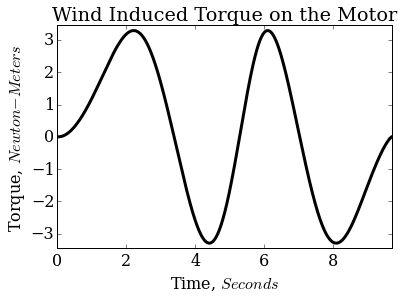

In [34]:
'''pyplot.figure(1);
pyplot.plot(t, TAUenv*Ratio, color='#003366', ls='-', lw=3);
pyplot.title('Wind Induced Torque on the Payload');
pyplot.ylabel('Torque (Nm)');
pyplot.xlabel('Time (Sec)');
pyplot.xlim(0,T);
pyplot.ylim(numpy.amin(TAUenv*Ratio)*1.05,numpy.amax(TAUenv*Ratio)*1.05);
'''
pyplot.figure(2);
pyplot.plot(t, TAUenv, color='black', ls='-', lw=3);
pyplot.title('Wind Induced Torque on the Motor');
pyplot.ylabel('Torque, $Newton-Meters$');
pyplot.xlabel('Time, $Seconds$');
pyplot.xlim(0,T);
pyplot.ylim(numpy.amin(TAUenv)*1.05,numpy.amax(TAUenv)*1.05);
print('Maximum Environmental Torque on the motor is', round(numpy.amax(abs(TAUenv)),3),'Newton-Meters with a windspeed of',round(Windspeed), 'MPH.');

The position profile for the payload (commented out) and the motor are plotted below. The approximated expected results tell us that the ramp up should look quadratic, changing to a period of linear movement followed by a quadratic ramp down.  Let's see...

Final Payload Rotation angle is 360.0 Degrees


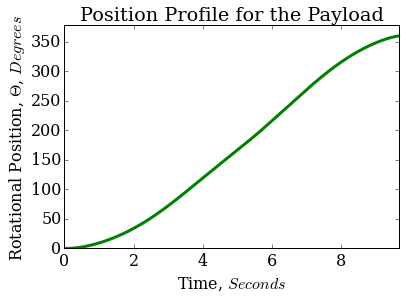

In [16]:
'''
pyplot.figure(1);
pyplot.plot(t, theta*180/numpy.pi, color='green', ls='-', lw=3);
pyplot.title('Position Profile for the Motor');
pyplot.ylabel('Rotational Position, $\Theta$, $Degrees$');
pyplot.xlabel('Time, $Seconds$')
pyplot.xlim(0,T);
pyplot.ylim(0,numpy.amax(theta)*180/numpy.pi*1.05);
'''
pyplot.figure(2);
pyplot.plot(t, theta*180/numpy.pi/Ratio, color='green', ls='-', lw=3);
pyplot.title('Position Profile for the Payload');
pyplot.ylabel('Rotational Position, $\Theta$, $Degrees$');
pyplot.xlabel('Time, $Seconds$')
pyplot.xlim(0,T);
pyplot.ylim(0,numpy.amax(theta)*180/numpy.pi/Ratio*1.05);
print('Final Payload Rotation angle is', round(numpy.amax(abs(theta)*180/numpy.pi/Ratio),3),'Degrees');

Wonderful! The position profile follows the approximated expected results very nicely.  How about the velocity profile?

Maximum Payload Rotational Velocity is 52.912 Degrees/Second


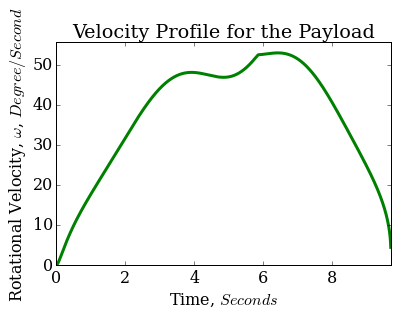

In [17]:
'''
pyplot.figure(1);
pyplot.plot(t, omegaRK2Ralston*180/numpy.pi, color='green', ls='-', lw=3)
pyplot.title('Velocity Profile for the Motor')
pyplot.ylabel('Rotational Velocity, $\omega$, $Degree/Second$')
pyplot.xlabel('Time, $Seconds$')
pyplot.xlim(0,T);
pyplot.ylim(0,numpy.amax(omegaRK2Ralston)*180/numpy.pi*1.05);
'''
pyplot.figure(2);
pyplot.plot(t, omegaRK2Ralston*180/numpy.pi/Ratio, color='green', ls='-', lw=3)
pyplot.title('Velocity Profile for the Payload')
pyplot.ylabel('Rotational Velocity, $\omega$, $Degree/Second$')
pyplot.xlabel('Time, $Seconds$')
pyplot.xlim(0,T);
pyplot.ylim(0,numpy.amax(omegaRK2Ralston)*180/numpy.pi/Ratio*1.05);
print('Maximum Payload Rotational Velocity is', round(numpy.amax(abs(omegaRK2Ralston)*180/numpy.pi/Ratio),3),'Degrees/Second');

The velocity profile has a pseudo-trapezoidal look to it, but there are some noteable differences. First, note the large signatures of the wind induced torque in the middle half of the cycle time from $3$ to $7$ $Seconds$ creating a sinusoidal wave instead of a constant flat velocity. Second, the "linear" ramp-up and -down exists but the slopes are different. This occurs due to the internal frictional torque within the motor that helps to slow down the motor and other effects seen in the controlling equation.  Take a look again at the equation for $\alpha$

$$\alpha = \frac{I_\rm{applied}(V_\rm{applied}-RI_\rm{applied})}{I_\rm{inertia}\omega}-\frac{\tau_\rm{environmental}}{I_\rm{inertia}}$$

It makes sense that the acceleration increases as $\omega$ decreases. This is also the reason for the difference in ramp-up time of around $3$ $Seconds$ and ramp-down time of around $1.5$ $Seconds$.

Note that the final omega value is around $4^{\circ}/Second$. This occurs since the $\Delta t$ used for this exercise is $0.0001$ $Seconds$ limiting the endpoint of the solution. Decreasing the $\Delta t$ by a factor of $10$ significantly increases the processing time to many minutes instead of the current $18$ $Seconds$.

Now that we know the velocity profile is different than the approximation, what should we expect for the acceleration profile?

Maximum Payload Rotational Acceleration is 354.952 Degrees/Second^2 with a maximum 1 second sustained acceleration of 14.159 Degrees/Second^2


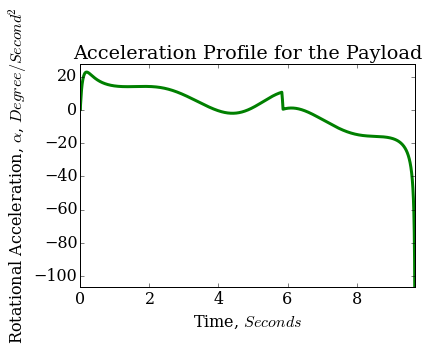

In [18]:
'''
pyplot.figure(1);
pyplot.plot(t, alpha*180/numpy.pi, color='green', ls='-', lw=3)
pyplot.title('Acceleration Profile for the Motor')
pyplot.ylabel('Rotational Acceleration, $\\alpha$, $Degree/Second^2$')
pyplot.xlabel('Time, $Seconds$')
pyplot.xlim(0,T);
pyplot.ylim(-numpy.amax(alpha)*180/numpy.pi*.01,numpy.amax(alpha)*180/numpy.pi*.01);
'''
pyplot.figure(2);
pyplot.plot(t, alpha*180/numpy.pi/Ratio, color='green', ls='-', lw=3)
pyplot.title('Acceleration Profile for the Payload')
pyplot.ylabel('Rotational Acceleration, $\\alpha$, $Degree/Second^2$')
pyplot.xlabel('Time, $Seconds$')
pyplot.xlim(0,T);
pyplot.ylim(numpy.amin(alpha)*180/numpy.pi*.3/Ratio,numpy.amax(alpha)*180/numpy.pi/Ratio+5);
print('Maximum Payload Rotational Acceleration is', round(numpy.amax(abs(alpha)*180/numpy.pi/Ratio),3),'Degrees/Second^2 with a maximum 1 second sustained acceleration of',round((alpha[int(1/dt)]*180/numpy.pi/Ratio+alpha[int(1.5/dt)]*180/numpy.pi/Ratio+alpha[int(2/dt)]*180/numpy.pi/Ratio)/3,3),'Degrees/Second^2');

What a difference from the approximated expected result of two constant aceleration lines! But knowing the differences in the velocity profile plot we should have expected this. The wind induced torque effects are definitely apparent throughout the middle $3$ to $7$ $Seconds$ creating the same sinusoidal effect as seen on the velocity profile. The most interesting aspect of the aceleration profile is the within the first and last half seconds of the cycle. The approximated expected result was a constant acceleration step function.  Here we see the "step function" capability of the motor based on many real-life factors. The motor has its highest accelerations at low speed (see the controlling equating again!) and hits a local maximum before evening out to $1$ $Second$ sustained aceleration of around $14^{\circ}/Second^2$.

Now its time to see the motor winding temperature profile.

Maximum Motor Winding Temeprature is 93.22 Degrees C after 9.6956 Seconds of operation at a current of 17.857 Amps and 28.0 Volts with an ambient temperature of 25 degrees C. After a total of 100 Seconds, the motor winding temperature has cooled to 39.84 degrees C.


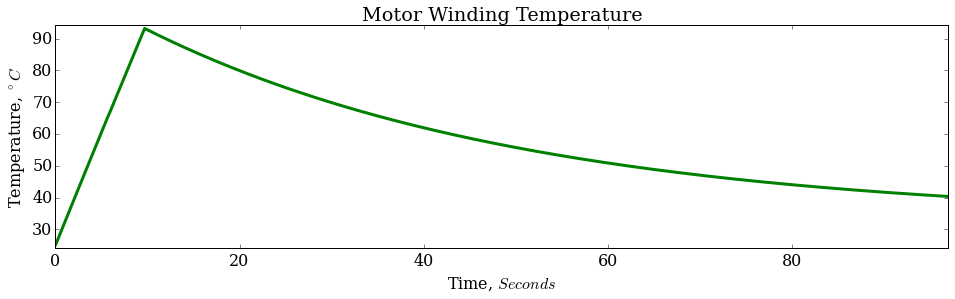

In [19]:
pyplot.figure(1, figsize=(16,4));
pyplot.plot(t, tempRK2Ralston, color='green', ls='-', lw=3);
pyplot.title('Motor Winding Temperature');
pyplot.ylabel('Temperature, $^{\circ}C$');
pyplot.xlabel('Time, $Seconds$');
pyplot.xlim(0,T*10);
pyplot.ylim(numpy.amin(tempRK2Ralston)-1,numpy.amax(tempRK2Ralston)+1);
print('Maximum Motor Winding Temeprature is', round(numpy.amax(tempRK2Ralston),3),'Degrees C after', round(T,4), 'Seconds of operation at a current of', round(Imax,3),'Amps and',numpy.amax(V),'Volts with an ambient temperature of',Tamb,'degrees C. After a total of', round(Tinitial,4), 'Seconds, the motor winding temperature has cooled to',round(tempRK2Ralston[N-1],2),'degrees C.' );

That's HOT!!  Its a good thing that the maximum rated motor winding temperature is $125^{\circ}C$.  The temeprature ramps very quickly at about $7^{\circ}C/Second$ during current application. To tell the truth, this "linear" looking ramp up was not expected. The ramp up should follow an exponential profile. Hmmm... Perhaps the power input into the system is just too large relative to the system time constant. We are only seeing the profile in the first $9.7$ $Seconds$ of a $31$ $Second$ time constant system. The cool down tracks along the typical exponential decay profile that is expected. If we look at the cool down profile for only the time between $10$ and $20$ $Seconds$, a similar "linear" look is present. This temperature design knowledge is a great example to pocket for future uses of DC motors since we are always trying to get the most power out of the smallest package.

## Final Words

Using a numerical method ODE solver helps us quantify the difference in a generally planned for motion profile and a realistic one. The use of a second-order Ralston method to solve a non-linear ODE system presents a significant L1-norm error difference when compared to the less accurate first-order Euler method.

## References and Sources
[1] http://openedx.seas.gwu.edu/courses/GW/MAE6286/2014_fall/about

[2] http://hades.mech.northwestern.edu/index.php/Brushed_DC_Motor_Theory

[3] https://en.wikipedia.org/wiki/Gimbal

[4] http://www.newmarksystems.com/gimbal-mounts/

[5] https://www.youtube.com/watch?v=wOK12HZSbu4

[6] http://www.maxonmotorusa.com/maxon/view/content/index

[7] http://www.icas.org/

[8] https://en.wikipedia.org/wiki/Time_constant

[9] https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods

[10] http://nbviewer.ipython.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/01_phugoid/01_02_Phugoid_Oscillation.ipynb


**Updates as of 12/19/2015**
* Fixed spelling errors
* Updated imports to remove unused items and to consilidate
* Added a sentence in requirements stating the focus of the exercise is the azimuth stage
* Updated $Latex$ format in charts and throughout the notebook
* Added a list of references and sources to the end of the document

###### The cell below loads the style of this notebook.

In [ ]:
from IPython.core.display import HTML
css_file = 'styles/numericalmoocstyle.css'
HTML(open(css_file, "r").read())